Theory

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import fingerprint_enhancer

Fingerprint image enhancement

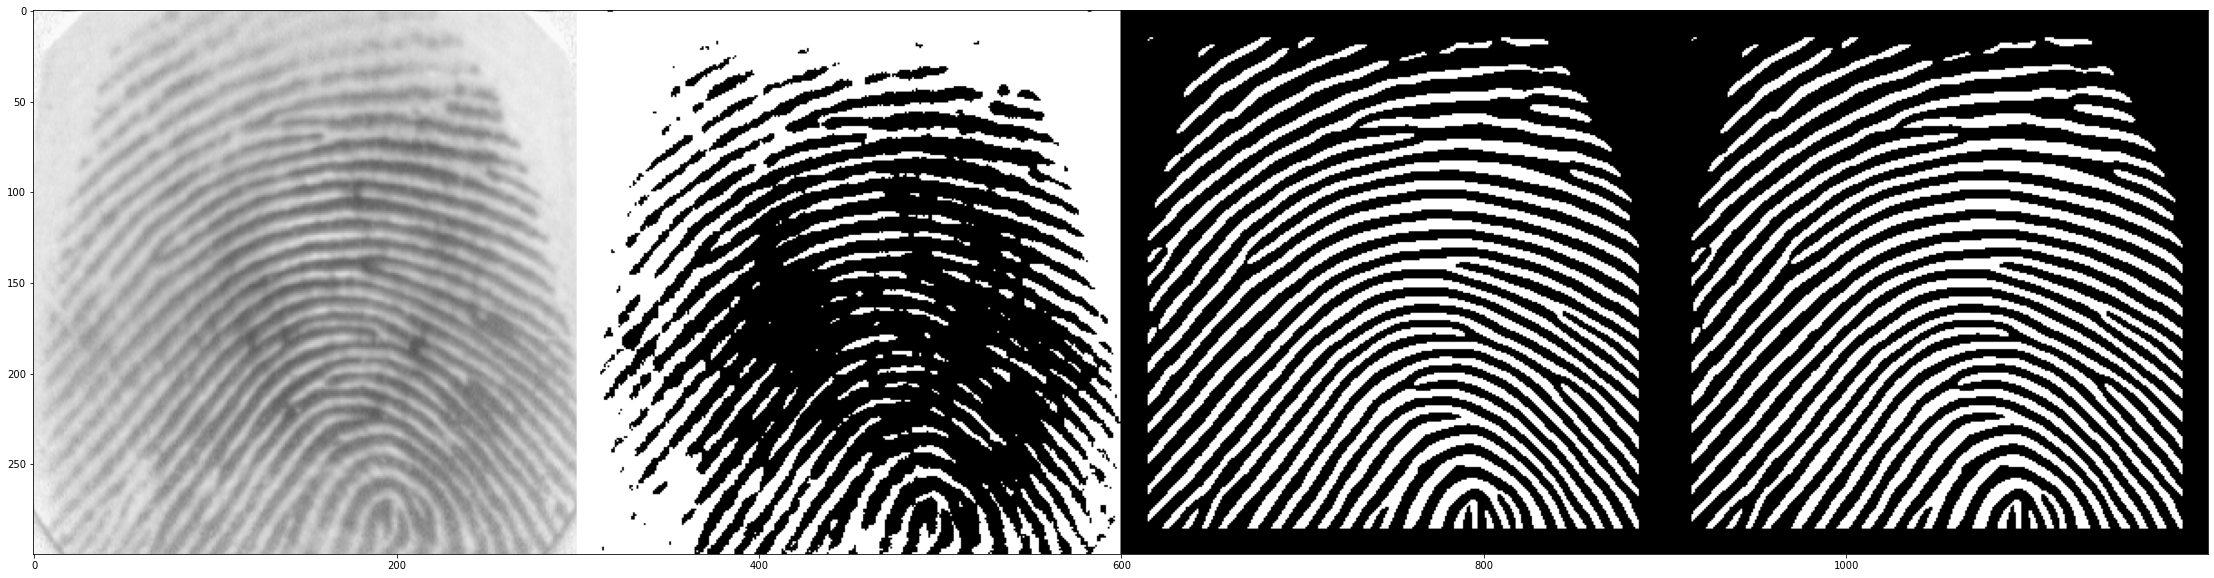

In [2]:
img = cv2.imread('DB1_B/101_1.tif', cv2.IMREAD_GRAYSCALE)
enhanced_img = fingerprint_enhancer.enhance_Fingerprint(img)
_, binarized_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
_, binarized_enhanced_img = cv2.threshold(enhanced_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure(figsize=(40,10))
plt.imshow(np.concatenate((img, binarized_img, enhanced_img, binarized_enhanced_img), axis=1), 'gray')

In [3]:
print((enhanced_img == binarized_enhanced_img).all())

True


Thinning and Pruning

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

pruning_kernels = [
    np.array([[0,-1,-1],
             [1, 1,-1],
             [0,-1,-1]], dtype=np.int),

    np.array([[ 0, 1, 0],
             [-1, 1,-1],
             [-1,-1,-1]], dtype=np.int),

    np.array([[-1,-1, 0],
             [-1, 1, 1],
             [-1,-1, 0]], dtype=np.int),

    np.array([[-1,-1,-1],
             [-1, 1,-1],
             [ 0, 1, 0]], dtype=np.int),

    np.array([[ 1,-1,-1],
             [-1, 1,-1],
             [-1,-1,-1]], dtype=np.int),

    np.array([[-1,-1, 1],
             [-1, 1,-1],
             [-1,-1,-1]], dtype=np.int),

    np.array([[-1,-1,-1],
             [-1, 1,-1],
             [-1,-1, 1]], dtype=np.int),

    np.array([[-1,-1,-1],
             [-1, 1,-1],
             [ 1,-1,-1]], dtype=np.int)]

thinning_kernels = [
    np.array([[-1,-1,-1],
             [-1, 1,-1],
             [ 1, 1, 1]], dtype=np.int),

    np.array([[-1,-1,-1],
             [ 1, 1,-1],
             [-1, 1,-1]], dtype=np.int),

    np.array([[ 1,-1,-1],
             [ 1, 1,-1],
             [ 1,-1,-1]], dtype=np.int),

    np.array([[-1, 1,-1],
             [ 1, 1,-1],
             [-1,-1,-1]], dtype=np.int),

    np.array([[ 1, 1, 1],
             [-1, 1,-1],
             [-1,-1,-1]], dtype=np.int),

    np.array([[-1, 1, -1],
             [-1, 1, 1],
             [-1,-1,-1]], dtype=np.int),

    np.array([[-1,-1, 1],
             [-1, 1, 1],
             [-1,-1, 1]], dtype=np.int),

    np.array([[-1,-1,-1],
             [-1, 1, 1],
             [-1, 1,-1]], dtype=np.int)]

def thinning(input_img, kernels = thinning_kernels):   
    temp = input_img.copy()
    result = input_img.copy()
    while True:
        for j in range(len(kernels)):
            result = result - cv2.morphologyEx(result, cv2.MORPH_HITMISS, kernels[j])
        if (temp == result).all():
            break;
        temp = result.copy()
    
    return result


def prune_image(img):
    X1 = thinning(img, pruning_kernels)

    #Find End Points
    X2 = np.zeros(img.shape, dtype=np.uint8)
    for i in range(len(pruning_kernels)):
        X2 = cv2.bitwise_or(X2,
                            cv2.morphologyEx(X1, cv2.MORPH_HITMISS, pruning_kernels[i]))

    #Dilate End Point
    X3 = cv2.bitwise_and(img, 
                         cv2.dilate(X2,
                                    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))))

    #Union of X1 & X3
    X4 = cv2.bitwise_or(X1, X3)
    
    return X4


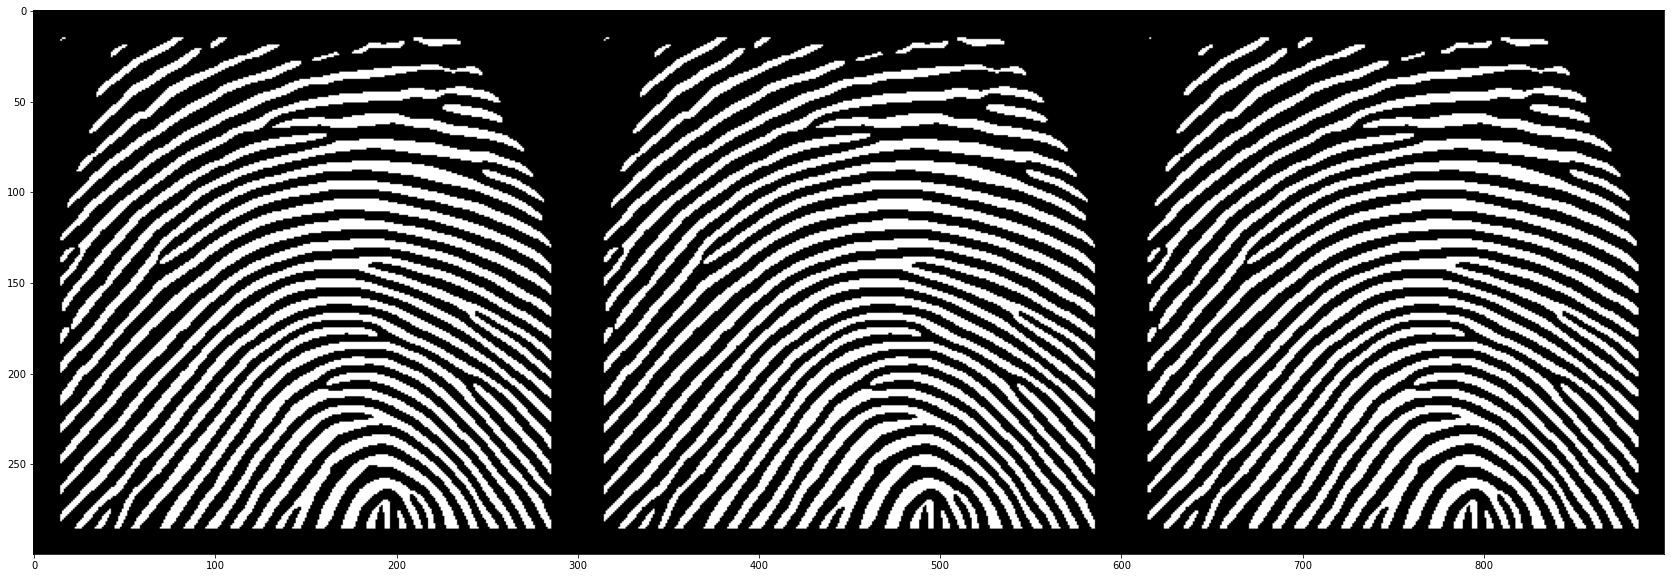

In [5]:
pruned_image = prune_image(enhanced_img)
thinned_image = thinning(enhanced_img)

plt.figure(figsize=(40,10))
plt.imshow(np.concatenate((thinned_image, enhanced_img, pruned_image), axis=1), 'gray')

In [6]:
print((enhanced_img == pruned_image).all())
print((enhanced_img == thinned_image).all())
print((pruned_image == thinned_image).all())

False
False
False


Spurious islands and holes removal

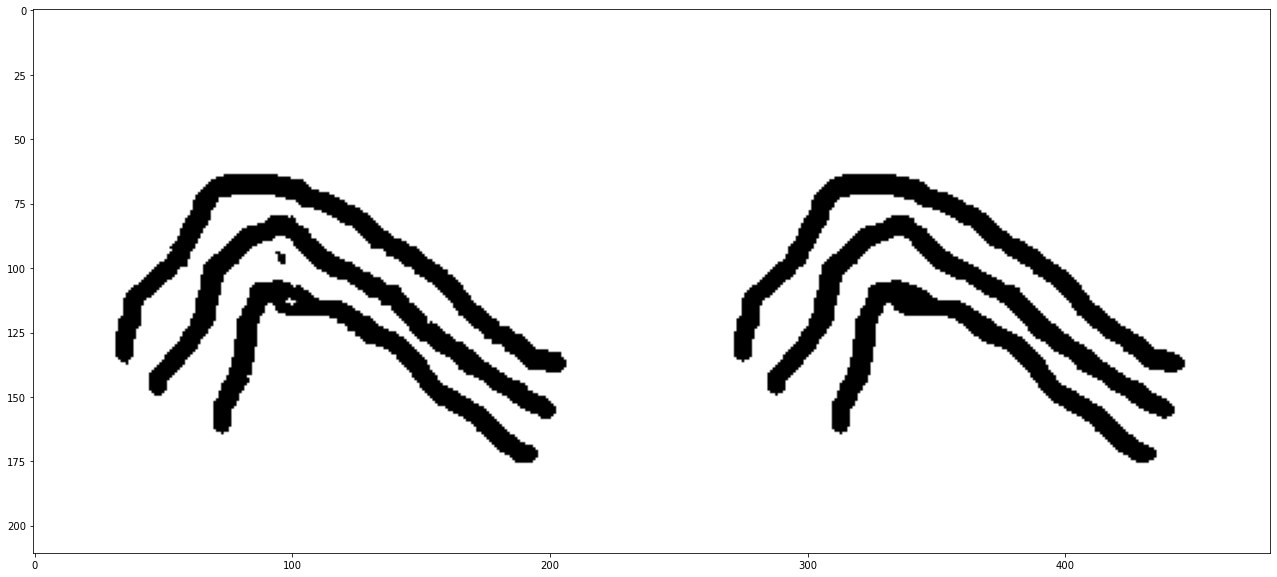

In [7]:
im_in = cv2.imread("spur-islands-and-holes.png", cv2.IMREAD_GRAYSCALE);


close_e = cv2.morphologyEx(prune_image(im_in), cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
open_e = cv2.morphologyEx(close_e, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)))

plt.figure(figsize=(40,10))
plt.imshow(np.concatenate((im_in, open_e), axis=1), 'gray')